In [4]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [5]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [6]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

iberdrola = df[df['empresa'] == 'Iberdrola']

iberdrola.shape

(1325, 10)

In [7]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

iberdrola = iberdrola [['date','open','high','low','close','adj close']]

iberdrola.shape

(1325, 6)

In [8]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

iberdrola['date'] = pd.to_datetime(iberdrola['date'], format="%Y-%m-%d")

iberdrola.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 23200 to 24524
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [9]:
# Paso 5: Ordenar el DF por fecha

iberdrola.sort_values(by='date',ascending= True, inplace=True)

iberdrola.head()

,date,open,high,low,close,adj close
23642,2019-01-02,6.948,7.032,6.864,6.998,5.574146
23210,2019-01-03,6.970,7.068,6.944,7.010,5.583704
24089,2019-01-04,7.036,7.128,7.024,7.062,5.625122
23200,2019-01-07,7.094,7.122,7.052,7.116,5.668137
23209,2019-01-08,7.092,7.150,7.076,7.090,5.647426


In [10]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

iberdrola = iberdrola[(iberdrola['date'] >= fecha_inicio) & (iberdrola['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

iberdrola.shape

(812, 6)

In [11]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=iberdrola['date'].min(), end=iberdrola['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

iberdrola = iberdrola.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

iberdrola = iberdrola.rename(columns={'index': 'date'})


In [12]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

iberdrola.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,11.800,11.945,11.790,11.905,10.319033
1,2021-01-05,11.850,11.910,11.700,11.720,10.158681
2,2021-01-06,11.840,12.235,11.775,12.230,10.600738
3,2021-01-07,12.320,12.405,12.220,12.285,10.648412
4,2021-01-08,12.345,12.570,12.305,12.505,10.839104
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,12.355,12.435,12.230,12.410,10.756758
8,2021-01-12,12.240,12.265,11.995,11.995,10.539726
9,2021-01-13,11.945,12.190,11.885,12.110,10.640772


In [13]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

iberdrola = iberdrola.fillna(method='ffill')

In [14]:
# Paso 10: Comprobar que se han introducido los valores correctamente


iberdrola.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,11.800,11.945,11.790,11.905,10.319033
1,2021-01-05,11.850,11.910,11.700,11.720,10.158681
2,2021-01-06,11.840,12.235,11.775,12.230,10.600738
3,2021-01-07,12.320,12.405,12.220,12.285,10.648412
4,2021-01-08,12.345,12.570,12.305,12.505,10.839104
5,2021-01-09,12.345,12.570,12.305,12.505,10.839104
6,2021-01-10,12.345,12.570,12.305,12.505,10.839104
7,2021-01-11,12.355,12.435,12.230,12.410,10.756758
8,2021-01-12,12.240,12.265,11.995,11.995,10.539726
9,2021-01-13,11.945,12.190,11.885,12.110,10.640772


In [15]:
# Paso 11: Establecer columna 'date' como índice para modelo

iberdrola = iberdrola.set_index('date')

iberdrola.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,11.800,11.945,11.790,11.905,10.319033
2021-01-05,11.850,11.910,11.700,11.720,10.158681
2021-01-06,11.840,12.235,11.775,12.230,10.600738
2021-01-07,12.320,12.405,12.220,12.285,10.648412
2021-01-08,12.345,12.570,12.305,12.505,10.839104
2021-01-09,12.345,12.570,12.305,12.505,10.839104
2021-01-10,12.345,12.570,12.305,12.505,10.839104
2021-01-11,12.355,12.435,12.230,12.410,10.756758
2021-01-12,12.240,12.265,11.995,11.995,10.539726


In [16]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

iberdrola.index = pd.DatetimeIndex(iberdrola.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

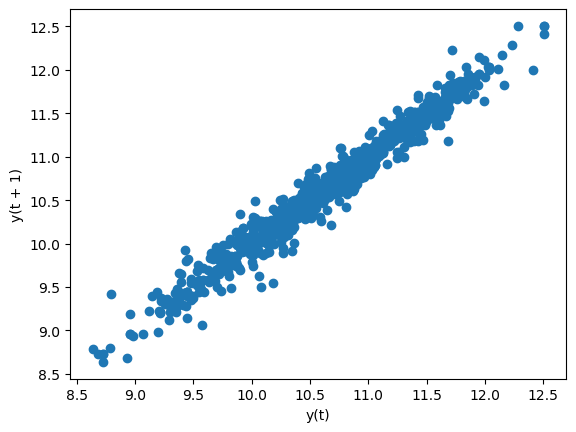

In [17]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(iberdrola.close)

In [18]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [19]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = iberdrola.close[:-10], iberdrola.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [20]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [21]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(iberdrola.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    10.895917
2024-02-22    10.891894
2024-02-23    10.887932
2024-02-24    10.884028
2024-02-25    10.880182
2024-02-26    10.876393
2024-02-27    10.872660
2024-02-28    10.868983
2024-02-29    10.865361
2024-03-01    10.861792
Freq: D, dtype: float64

In [22]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    10.935
2024-02-22    10.750
2024-02-23    10.630
2024-02-24    10.630
2024-02-25    10.630
2024-02-26    10.515
2024-02-27    10.535
2024-02-28    10.480
2024-02-29    10.620
2024-03-01    10.505
Freq: D, Name: close, dtype: float64

In [23]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.26333082250844325

In [24]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,10.935,10.895917,-0.039083
2024-02-22,10.750,10.891894,0.141894
2024-02-23,10.630,10.887932,0.257932
2024-02-24,10.630,10.884028,0.254028
2024-02-25,10.630,10.880182,0.250182
2024-02-26,10.515,10.876393,0.361393
2024-02-27,10.535,10.872660,0.337660
2024-02-28,10.480,10.868983,0.388983
2024-02-29,10.620,10.865361,0.245361
2024-03-01,10.505,10.861792,0.356792
